# TCSS 588 BioInformatics Project: Visualization
## Siri Sadashiva

### README
#### The below cell installs all the required dependencies required to run for this notebook. If the installation fails, please install the following by running the commands in the terminal:

### Scikit
1. conda install scikit-learn (OR)
2. pip install -U scikit-learn

---------------------------------------------------------------------------------------------------------------------
### Matplotlib
1. conda install -c conda-forge matplotlib (OR)
2. pip install --upgrade setuptools 
   pip install matplotlib

---------------------------------------------------------------------------------------------------------------------

### Pandas:

conda install pandas (OR)
pip install pandas

---------------------------------------------------------------------------------------------------------------

### Numpy 

conda install -c anaconda numpy (OR)
pip install numpy

---------------------------------------------------------------------------------------------------------------
### Scipy

pip install scipy

---------------------------------------------------------------------------------------------------------------
### Plotly

pip install plotly

pip install plotly --upgrade

---------------------------------------------------------------------------------------------------------------

### Other requirements:

1. When running the BioInformatics_AML.ipynb notebook, please make sure all the folders Clinical_Data, Expn_Data, Manifest_Data and clean.py file are present in the same directory.
2. While reading the csv files, change the pathname to read the files from the current directory. 


In [113]:
%matplotlib inline
!pip install --user scikit-learn
!pip3 install --user seaborn==0.9.0 
!pip install matplotlib-venn
!pip install scipy
!pip install plotly 
!pip install plotly --upgrade

    100% |████████████████████████████████| 35.7MB 181kB/s ta 0:00:011    92% |█████████████████████████████▌  | 32.8MB 3.1MB/s eta 0:00:01
  Stored in directory: /Users/sirisadashiva/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
  Found existing installation: plotly 2.6.0
    Uninstalling plotly-2.6.0:
      Successfully uninstalled plotly-2.6.0


In [114]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from clean import assay_transpose
from clean import manifest_clinical_merge
from clean import assay_clinical_merge
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from matplotlib_venn import venn2
import seaborn as sns


# I. Data Preprocessing
### Please make sure to run the pd.read_csv command by specififying the correct directory that contains the csv file 

In [86]:
pd.options.mode.chained_assignment = None
manifest_df = pd.read_csv('../BioInformatics_Project/Manifest_Data/GCD_TARGET_Data_Manifest_AML_NBL_WT_RT.csv')
aml_disc_df = pd.read_excel('../BioInformatics_Project/Clinical_Data/TARGET_AML_ClinicalData_20160714.xlsx')
AML_df = manifest_clinical_merge(manifest_df, aml_disc_df, 'TARGET-AML')
assay_df = pd.read_csv('../BioInformatics_Project/Expn_Data/TARGET_NBL_AML_RT_WT_TMMCPM_log2_Norm_Counts.csv.zip')
assay_t_df = assay_transpose(assay_df)
AML_genes = assay_clinical_merge(assay_t_df, AML_df)

In [87]:
df1 = AML_genes[AML_genes['Diagnostic ID'].isin(('09A', '03A', '01A'))]
df2 = df1[df1['Risk group'] != 'Unknown'].copy()
df2['Risk_Group'] = df2['Risk group'].apply(lambda x: (x == 'Low') * 1)


In [88]:
data = df2.iloc[:,:-1]
X = data.iloc[:,84:-4]
X = X.apply(pd.to_numeric)
y = df2.loc[data.index, 'Risk_Group']

In [89]:
X.shape

(137, 21403)

In [90]:
y.value_counts()

0    77
1    60
Name: Risk_Group, dtype: int64

#### Total count of:  Risk_Group 'Low' = 60;  Risk_Group 'High' = 77

# II. Feature Selection: Correlation
### Calculating correlation coefficients for all the genes

In [91]:
correlation_matrix = X.corr()

In [92]:
#Get highly correlated co-efficients
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.80)]

#drop highly correlated coefficients 
for i in to_drop:
    del X[i]
    
X.shape

(137, 16841)

### After feature selection, we have 16841 genes out of 21403 genes

# III. Modeling

### Split the data into test and train sets 

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=8)

### Method: Random Forest Classification

In [108]:
#Initialize K-Fold: k = 10
kf = KFold(n_splits=10,shuffle=True)

#Random Forest Classifier
clf = RandomForestClassifier(n_estimators=80)

#Initialize predictions
predictions =[]

#Run 10 times
for k, (train, test) in enumerate(kf.split(X, y)):
    #Fit and train the model
    clf.fit(X_train,y_train)
    
    #Get the prediction
    predictions.append(clf.score(X_test, y_test))

### Calculate Metrics

Accuracy of the Random Forest Classifier is 
0.928571428571
------------------------------------------------
Confusion Matrix:
[[18  1]
 [ 1  8]]
------------------------------------------------
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.95      0.95        19
          1       0.89      0.89      0.89         9

avg / total       0.93      0.93      0.93        28

------------------------------------------------


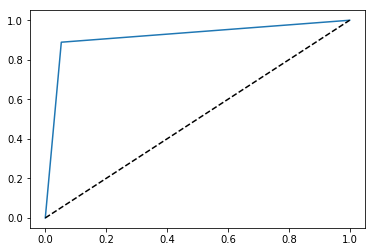

Area under curve (AUC):  0.918128654971


In [109]:
#Accuracy 
print("Accuracy of the Random Forest Classifier is ")
print(sum(predictions) / float(len(predictions)))
print("------------------------------------------------")

#Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))
print("------------------------------------------------")

#Classification Report
print("Classification Report:")
print(classification_report(y_test, clf.predict(X_test)))
print("------------------------------------------------")

#Area Under Curve 
y_score = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))


### Feature Importance: Top 10 Genes

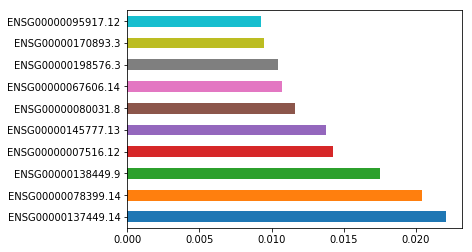

In [111]:
(pd.Series(clf.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')) 

In [97]:
#pd.set_option('display.max_columns', None)

# IV. Visualization

In [98]:
#df2['Low Risk'].value_counts()
#pd.set_option('display.max_columns', None)
temp = df2.loc[df2['Risk_Group'] == 0]
temp2 = df2.loc[AML_genes['Gender'] == 'Female']
temp3 = df2.loc[AML_genes['Gender'] == 'Male']

df2['FLT3_ITD_isPositive'] = df2['FLT3/ITD positive?'].apply(lambda x: 'No' if(x == 'NO') else 'Yes')

print("Total number of women and men: ")
df2['Gender'].value_counts()





Total number of women and men: 


Female    69
Male      68
Name: Gender, dtype: int64

### Venn Diagram that show how many women have high risk


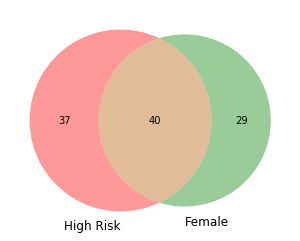

In [99]:
# PLOTTING VENN DIAGRAM
plt.figure(figsize=(5,5))
set1 = set(temp['id'])
set2 = set(temp2['id'])

venn2([set1, set2], ('High Risk', 'Female'))
plt.show()

### Venn Diagram that shows how many men have high risk


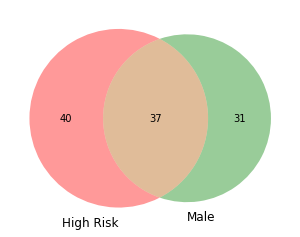

In [100]:
plt.figure(figsize=(5,5))
set1 = set(temp['id'])
set2 = set(temp3['id'])

venn2([set1, set2], ('High Risk', 'Male'))
plt.show()

### From the above plots we can see the number of women having high risk is greater than the number of men having high risk

### Factor plot that shows the division of risk groups by the vital status

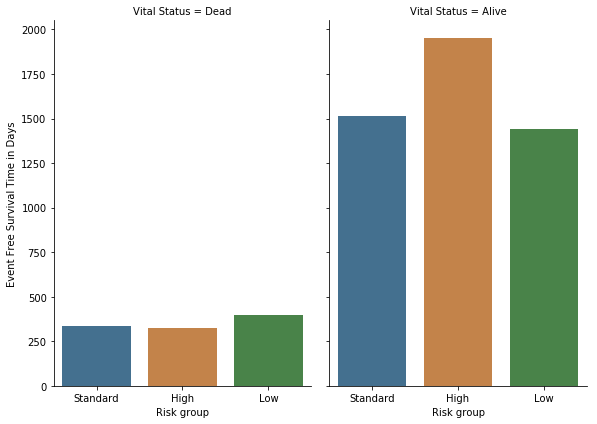

In [101]:
g = sns.catplot(x="Risk group", y="Event Free Survival Time in Days",col = "Vital Status",data=df2, saturation=.5,kind="bar", ci=None, height=6,aspect=.7)


### Factorplot that shows the division of risk groups by FLT3_ITD positive

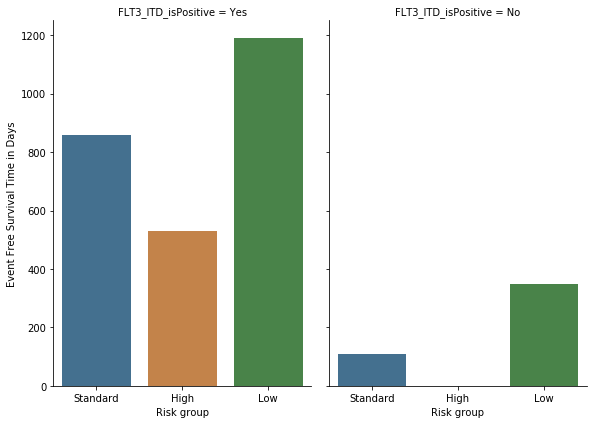

In [102]:
g = sns.catplot(x="Risk group", y="Event Free Survival Time in Days",col = "FLT3_ITD_isPositive",data=df2, saturation=.5,kind="bar", ci=None, height=6,aspect=.7)


### Heatmap of the top ten genes identified by Random Forest Classification Model

In [115]:
# If the following imports fail, please visit https://plot.ly/ipython-notebooks/bioinformatics/ and import the necessary libraries mentioned
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import *



In [104]:
cols = ['ENSG00000137449.14','ENSG00000166979.11','ENSG00000164929.15','ENSG00000160013.7','ENSG00000129194.6', 
'ENSG00000132470.12','ENSG00000139117.12','ENSG00000138028.13','ENSG00000144668.10','ENSG00000116176.6' ]

data_dist = pdist(df2[cols].as_matrix().transpose())
data = Data([
    Heatmap(
        z=squareform(data_dist), colorscale='YIGnBu',
        x=cols,
        y=cols,     # y-axis labels
    )
])
layout = Layout(
    title='Heatmap of Top Ten Genes Identified By Random Forest Classification',
    autosize=False,
    margin=Margin(
        l=200,
        b=200,
        pad=4
    ),
    xaxis=XAxis(
        showgrid=False, # remove grid
        autotick=False, # custom ticks
        dtick=1,        # show 1 tick per day
    ),
    yaxis=YAxis(
        showgrid=False,   # remove grid
        autotick=False,   # custom ticks
        dtick=1           # show 1 tick per day
    ),
)
fig = Figure(data=data, layout=layout)
py.iplot(fig, width=900, height=900)